#### Import necessary packages

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import logging
import time


#### Check mps is avaliable

In [23]:
# Check mps is avaliable
if not torch.backends.mps.is_available():
    device = torch.device('cpu')
else:
    device = torch.device('mps')

print(f"Using device: {device}")

Using device: mps


#### Fix random seed

In [24]:
# Set random seed
seed_np = np.random.seed(42)
seed = torch.manual_seed(42)

#### Process data

In [25]:
# Load SST data from the NetCDF file using xarray
ds = xr.open_dataset('./sst.mon.mean.trefadj.anom.1880to2018.nc')
sst_data = ds['sst'].values  # shape (139*12, 180, 360), (time, lat, lon)

# Reshape SST data to be (-1, 12, 180, 360) for (years, months, lat, lon)
years = sst_data.shape[0] // 12
sst_data = sst_data.reshape(years, 12, 180, 360)

# Function to process anomaly data and get labels based on specified thresholds
def get_anomaly_labels(file_path, start_year=1880, end_year=2018):
    # Load label data
    sst_labels_raw = pd.read_csv(file_path, delim_whitespace=True, header=None)

    # Set columns (Years and Months)
    columns = ['Year'] + [f'Month_{i}' for i in range(1, 13)]
    sst_labels_raw.columns = columns
    sst_labels_raw.set_index('Year', inplace=True)

    # Filter years from start_year to end_year
    sst_labels_raw = sst_labels_raw.loc[start_year:end_year]

    # Replace placeholder values with NaN and interpolate or remove
    sst_labels_raw.replace(-99.99, np.nan, inplace=True)
    sst_labels_raw.interpolate(method='linear', limit_direction='both', axis=0, inplace=True)

    # Calculate the 3-month rolling mean
    sst_labels = sst_labels_raw.rolling(window=3, axis=1, center=True).mean()

    # Function to label each year based on 3-month averages
    def label_year(row):
        el_nino_count = 0
        la_nina_count = 0
        for i in range(len(row) - 2):
            three_month_avg = row[i:i+3].mean()
            if three_month_avg >= 0.5:
                el_nino_count += 1
                la_nina_count = 0
            elif three_month_avg <= -0.5:
                la_nina_count += 1
                el_nino_count = 0
            else:
                el_nino_count = 0
                la_nina_count = 0
            
            if el_nino_count >= 5:
                return 2  # El Niño
            if la_nina_count >= 5:
                return 0  # La Niña
        return 1  # Neutral

    # Apply the labeling function to each year
    labels = sst_labels.apply(label_year, axis=1).reset_index()
    labels.columns = ['Year', 'Label']

    return labels

data_path = './nino34.long.anom.data.txt'
sst_labels = get_anomaly_labels(data_path)

print(sst_data.shape)
print(sst_labels.shape)

(139, 12, 180, 360)
(139, 2)


#### Hyperparameters

In [26]:
# Hyperparameters
params = {
    "lr": 1e-2,
    "weight_decay": 1e-4,
    "epochs": 10,
    "batch_size": 4,
    "num_workers": 0
}

#### Setting dataset

In [27]:
# Splitting the dataset
X_train_val, X_test, y_train_val, y_test = train_test_split(sst_data, sst_labels, test_size=0.1, random_state=seed_np)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.222, random_state=seed_np)  # 0.222 * 0.9 ≈ 0.2

# Check shapes
print(X_train.shape, y_train.shape)  # (97, 12, 180, 360) (97, 2)
print(X_val.shape, y_val.shape)  # (28, 12, 180, 360) (28, 2)
print(X_test.shape, y_test.shape)  # (14, 12, 180, 360) (14, 2)


class SSTDataset(Dataset):
    def __init__(self, X, y):
        y = y.values
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y[:, 1], dtype=torch.long)  # Extract only the label column

    def __len__(self):
        return self.X.shape[0] * self.X.shape[1]  # Total number of samples

    def __getitem__(self, idx):
        year = idx // 12
        month = idx % 12
        return self.X[year], self.y[year]  # (12, 180, 360), (2)


# Initialize DataLoader objects again to ensure correctness
train_loader = DataLoader(SSTDataset(X_train, y_train), batch_size=params['batch_size'], shuffle=True, num_workers=params['num_workers'])
val_loader = DataLoader(SSTDataset(X_val, y_val), batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])
test_loader = DataLoader(SSTDataset(X_test, y_test), batch_size=params['batch_size'], shuffle=False, num_workers=params['num_workers'])


(97, 12, 180, 360) (97, 2)
(28, 12, 180, 360) (28, 2)
(14, 12, 180, 360) (14, 2)


#### Define model

In [28]:
# Model definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(12, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after two pooling operations (180/4, 360/4)
        self.num_flat_features = 64 * (180 // 4) * (360 // 4)
        
        self.fc1 = nn.Linear(self.num_flat_features, 512)
        self.fc2 = nn.Linear(512, 3)  # Output layer for 3 classes: El Niño, La Niña, Neutral

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, self.num_flat_features)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output logits for three classes
        return x

#### Configurations

In [29]:
# Initialize model, optimizer, and loss function
model = CNN().to(device)  # mps
optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.CrossEntropyLoss()

#### Training and Testing

In [30]:
# Configure logging
logging.basicConfig(filename='training.log', level=logging.INFO)

# Loss array to keep track of train and validation losses
Loss = np.zeros((params["epochs"], 2))  # epochs, train/test
Accuracy = np.zeros((params["epochs"], 2))  # epochs, train/test

def calculate_accuracy(labels, preds):
    correct = (preds == labels).sum().item()
    accuracy = correct / labels.size(0)
    return accuracy

def train_model():
    best_val_loss = float('inf')
    start_time = time.time()

    for epoch in tqdm(range(params["epochs"]), desc='Training progress'):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        Loss[epoch, 0] = avg_train_loss
        Accuracy[epoch, 0] = train_accuracy

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        Loss[epoch, 1] = avg_val_loss
        Accuracy[epoch, 1] = val_accuracy

        # Log the epoch results
        message = f'Epoch {epoch + 1}/{params["epochs"]}\n'
        message += f'           Train set - loss: {avg_train_loss:.4f}, accuracy: {train_accuracy:.4f}\n'
        message += f'           Validation set - loss: {avg_val_loss:.4f}, accuracy: {val_accuracy:.4f}\n'

        # Write the message to the log file
        logging.info(message)

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            logging.info('Validation loss decreased, saving model...')

    # Calculate total training time
    train_time = time.time() - start_time
    print(f'Training time for {params["epochs"]} epochs: {train_time:.2f} seconds')

def test_model(model_path='best_model.pth'):
    # Load the best model for testing
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Testing phase
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_test_loss = running_test_loss / len(test_loader)
    accuracy = correct / total * 100
    logging.info(f'Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Training
train_model()

# Evaluate the model
test_model()

Training progress: 100%|██████████| 10/10 [04:36<00:00, 27.67s/it]


Training time for 10 epochs: 276.68 seconds


#### Visualize result

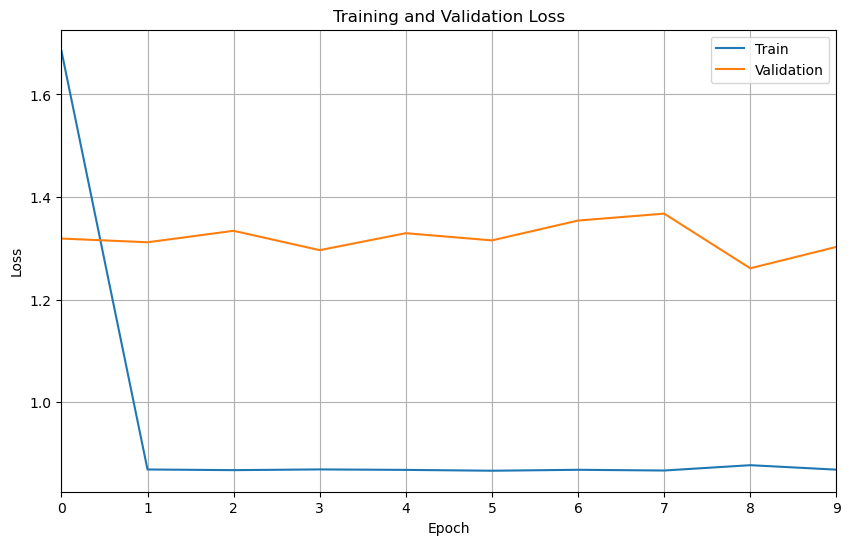

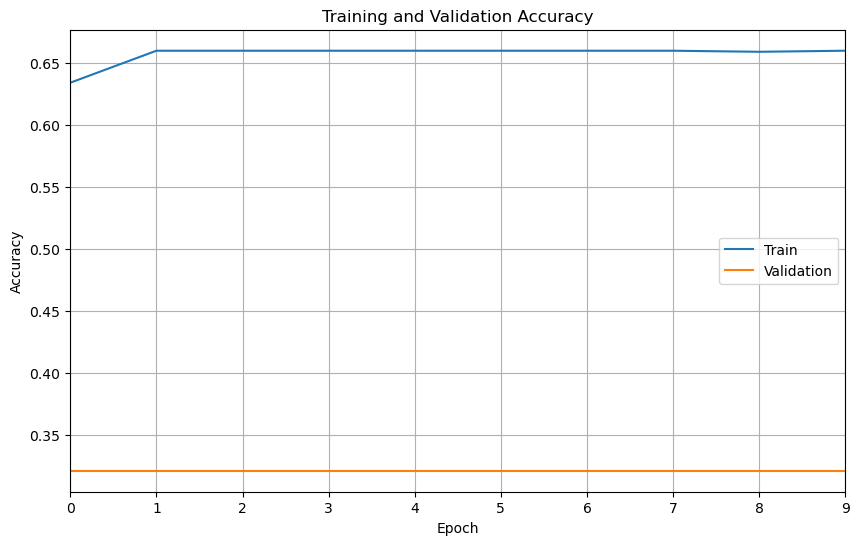

In [31]:
# Visualize the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(Loss[:, 0], label='Train')
plt.plot(Loss[:, 1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlim(0, params["epochs"] - 1)
plt.legend()
plt.grid()
plt.show()

# Visualize the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(Accuracy[:, 0], label='Train')
plt.plot(Accuracy[:, 1], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlim(0, params["epochs"] - 1)
plt.legend()
plt.grid()
